# Start Pooling

# Start Pooling

In [ ]:
#import general packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import n_fct_t_rl_thm_ll as bond_fct
import prem_ibrd as prib
import simulate_multi_cty_bond as smcb

In [ ]:
bond_cache = {}

def get_bond_metrics(pool, pay_dam_pool_it, nominal_pool_it):
    pool_key = tuple(sorted(pool))  # Create a unique key for the pool
    if pool_key not in bond_cache:
        # If result isn't cached, compute and store it
        pay_dam_temp = {c: pay_dam_pool_it[c] for c in pool}
        nominal_temp = {c: nominal_pool_it[c] for c in pool}
        bond_metrics, returns, tot_coverage, premium_dic, nominal, es_metrics, MES_cty = bond_fct.mlt_cty_bond(
            countries=pool,
            pay_dam_df_dic=pay_dam_temp,
            nominals_dic=nominal_temp,
            opt_cap=True,
        )
        bond_cache[pool_key] = {
            "Returns": returns
            }
    return bond_cache[pool_key]

## Define Countries and Variables for Cat Bond Development

In [ ]:
#choose country
countries = [212, 670, 308, 659, 662, 882, 174, 548] #480, 388, 52, 776, 570, 184
countries_str = ["DMA", "VCT", "GRD", "KAN", "LCA", "WSM", "COM", "VUT"]
countries_150 = [548] #388
countries_30 = [212, 670, 308, 659, 662, 882, 174] #480, 52, 776, 570, 184
#minimum damage to be protected per grid cell calculated using return period
lower_rp = 100

#number of simulated years
r = 10000

#set risk free rate, either single value or array
rf_rates = 0.00


#inititate IBRD premium calculation function
params_ibrd = prib.init_prem_ibrd(want_plot=False)
a, k, b = params_ibrd
#set risk muliplier reported by artems
artemis_multiplier = 4.11

#set sharpe ratio to beat
target_sharpe = 0.5

prot_share = 0.008
lower_share = 0.045
prot_rp = 250
lower_rp = 30

In [ ]:
shuffled_vector = np.random.permutation(countries)
n = len(countries)
# Split into two equal parts
half_n = n // 2
pool1 = shuffled_vector[:half_n]
pool2 = shuffled_vector[half_n:]
print("Pool 1: ",pool1)
print("Pool 1: ",pool2)

## Designe Single Country Bonds
### Define Cat Bond function

### Design Cat Bond for Country 1

In [ ]:
#define empty dictionaries
bond_metrics_sng_dic = {}
returns_sng_dic = {}
premium_dic_sng_dic = {}
nominal_sng_dic = {}
pay_dam_df_sng_dic = {}
es_metrics_sng_dic = {}
int_grid_sng_dic = {}
imp_per_event_flt_sng_dic = {}
imp_admin_evt_flt_sng_dic = {}
ann_losses_dic = {}

In [ ]:
for cty in countries:
    if cty in bond_metrics_sng_dic:
        print(f"Bond for {cty} already calculated, skipping.")
        continue
    print(f'Create bond for {cty}')
    if cty in countries_150:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=150,
                                                                                                                                                    grid_size=3000,
                                                                                                                                                    buffer_grid_size=3,
                                                                                                                                                    incl_plots=False)
    if cty in countries_30:
        bond_metrics, returns, premium_dic, nominal, pay_dam_df, es_metrics, int_grid, imp_per_event_flt, imp_admin_evt_flt, ann_losses = bond_fct.sng_cty_bond(country=cty,
                                                                                                                                                    prot_rp=prot_rp, 
                                                                                                                                                    to_prot_share=lower_share,
                                                                                                                                                    buffer_distance_km=105,
                                                                                                                                                    res_exp=30,
                                                                                                                                                    grid_size=1000,
                                                                                                                                                    buffer_grid_size=1,
                                                                                                                                                    incl_plots=False)
    bond_metrics_sng_dic[cty] = bond_metrics
    returns_sng_dic[cty] = returns
    premium_dic_sng_dic[cty] = premium_dic
    nominal_sng_dic[cty] = nominal
    pay_dam_df_sng_dic[cty] = pay_dam_df
    es_metrics_sng_dic[cty] = es_metrics
    int_grid_sng_dic[cty] = int_grid
    imp_per_event_flt_sng_dic[cty] = imp_per_event_flt
    imp_admin_evt_flt_sng_dic[cty] = imp_admin_evt_flt
    ann_losses_dic[cty] = ann_losses

In [ ]:
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.core.problem import StarmapParallelization
from pymoo.indicators.hv import Hypervolume
from pymoo.core.callback import Callback
from multiprocessing.pool import ThreadPool

from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation


from pymoo.operators.crossover.hux import HalfUniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.util.ref_dirs import get_reference_directions

from pooling_functions_ciullo import calc_pool_conc, MinConcProblem, MinNumCntrProblem, MinConcsProblem, MinNumCntrProblems, calc_pools_conc


Step 1 - Pool with the minimum concentration
Step 2 - Smallest set of countries within this pool maintaining min conc

[False False False  True False  True  True  True]


In [385]:
sng_ann_ret = {}
for idx, cty in enumerate(countries):
    sng_ann_ret[cty] = np.array(ann_losses_dic[cty]['losses'].apply(sum)) * nominal_sng_dic[cty]
sng_ann_ret = pd.DataFrame(sng_ann_ret)
   
    
RT = 200

alpha = 1-1/RT 
alpha

0.995

Repetitions:   0%|          | 0/100 [00:00<?, ?it/s]

[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[0 3 4 7]
[6.04902613e+07 6.96073545e+07 4.41990592e+08 2.33734253e+07]
[1.34186465e+08 2.56398827e+08 2.35273027e+07 1.89119045e+06]
[0 1 7]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 2 4 5 6]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3 5 6 7]
[2.54207516e+08 3.67809383e+07 3.99135005e+06 3.12438635e+07]
[4.02817458e+07 2.31119470e+08 5.19571737e+07 4.53189868e+08]
[2 5]
[3.39080170e+08 9.18867743e+06]
[5.78389696e+07 1.90146793e+08 7.14389491e+07 4.57094640e+08
 0.00000000e+00 1.67826170e+07]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.128

C:\Users\kaibe\AppData\Local\Temp\ipykernel_5828\23891594.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
Repetitions:   1%|          | 1/100 [00:00<01:24,  1.17it/s]

[0 2 4 6]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 1 2 3 4 7]
[5.54918623e+07 2.03066057e+08 5.59498983e+07 6.69925684e+07
 4.28552362e+08 2.19137124e+07]
[2.45875554e+08 2.47983913e+06]
[1 4 6]
[2.29264596e+08 4.72611766e+08 0.00000000e+00]
[8.06674001e+07 1.22793277e+08 1.79674250e+08 3.74257141e+07
 3.33322694e+07]
[1 2 3 4 5 6 7]
[2.23185683e+08 6.10446017e+07 5.18760343e+07 4.13915906e+08
 1.94008688e+07 0.00000000e+00 2.90200697e+07]
[1.82627318e+08]
[0 2 3 6]
[6.61110697e+07 1.97280275e+08 1.36065714e+08 1.16287404e+06]
[2.30996631e+08 4.59233603e+08 1.43747019e+07 2.22124426e+07]
[4 5]
[4.96875404e+08 1.35586525e+07]
[5.85116810e+07 1.59722586e+08 1.53658816e+08 1.26655875e+08
 1.60660229e+06 2.30859356e+07]
[0 1 2 3 5]
[5.38265229e+07 1.64547154e+08 1.57853887e+08 1.13332318e+08
 2.71772173e+07]
[4.94355530e+08 0.00000000e+00 2.23511045e+07]
[0 3 5 7]
[1.04125624e+08 2.23210431e+08 3.55289235

Repetitions:   2%|▏         | 2/100 [00:01<01:19,  1.24it/s]

[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[2.83313050e+08 2.47068431e+07]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2 5 6]
[3.33199793e+08 1.41815585e+07 2.47983913e+06]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2 5 6]
[3.33199793e+08 1.41815585e+07 2.47983913e+06]
[1.54264132e+08 1.68529623e+08]
[0 2]
[2.11396607e+07 3.35308922e+08]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 4]
[6.19366780e+07 4.87522301e+08]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 4 5 6]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.42443561e+08 8.05739941e+07 3.

Repetitions:   3%|▎         | 3/100 [00:02<01:20,  1.21it/s]

[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[0 2 3 4 6]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[2 4 6 7]
[4.06507468e+07 4.75174948e+08 0.00000000e+00 2.89461164e+07]
[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 3 4 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[0 2 3 7]
[8.83265397e+07 1.19795369e+08 1.92740818e+08 3.55491425e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[0 2 3 4]
[8.37948186e+07 6.56943348e+07 1.03

Repetitions:   4%|▍         | 4/100 [00:03<01:21,  1.18it/s]

[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[1 5 7]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[1 5 7]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[5.02371623e+08 0.00000000e+00]
[0 1 3 5 7]
[9.12132646e+07 1.18951433e+08 1.66692902e+08 3.81737731e+07
 4.19482740e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[1 2 3 5 6 7]
[1.55794032e+08 2.03403183e+08 9.44567803e+07 2.75356254e+07
 0.00000000e+00 2.70205562e+07]
[6.19366780e+07 4.87522301e+08]
[0 1 4 5]
[3.96066706e+07 2.16004367e+08 4.68534894e+08 1.36484449e+07]
[2.93343366e+08 6.39036468e+07 1

Repetitions:   5%|▌         | 5/100 [00:04<01:25,  1.11it/s]

[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[4.44073880e+07 2.85289096e+08]
[2 4 5 6]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[2.98722115e+08]
[0 3 5]
[1.00393184e+08 2.52894287e+08 3.03007515e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[7.25713470e+07 2.76099072e+08 1.16287404e+06]
[2]
[3.40719346e+08]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432

Repetitions:   6%|▌         | 6/100 [00:05<01:22,  1.15it/s]

[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[0 5 6]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[7.37308635e+07 4.75561751e+08]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 5 6]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[3.19093007e+08 5.52906496e+07]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[4.06507468e+07 4.75174948e+08 0.00000000e+00 2.89461164e+07]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[3.19093007e+08 5.52906496e+07]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+0

Repetitions:   7%|▋         | 7/100 [00:06<01:22,  1.12it/s]

[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[2.93150176e+08 2.08437654e+07]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.94646038e+08 1.72022213e+07]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[0 2 6 7]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[2.45875554e+08]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.94646038e+08 1.72022213e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[0 2 4 6 7

Repetitions:   8%|▊         | 8/100 [00:06<01:21,  1.13it/s]

[0 4 7]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[0 2 3 4 5 7]
[7.41984643e+07 6.54292995e+07 9.64605139e+07 3.85042191e+08
 1.68405316e+07 3.55779093e+07]
[2.99087445e+08 1.04079358e+06]
[2 3 4 5 7]
[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[2.99087445e+08 1.04079358e+06]
[2]
[3.40719346e+08]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[0 7]
[2.72377646e+07 2.39459397e+08]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[2.99087445e+08 1.04079358e+06]
[0 3 7]
[1.00455817e+08 2.47256546e+08 3.64073384e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[0 2 7]
[2.50038

Repetitions:   9%|▉         | 9/100 [00:07<01:19,  1.15it/s]

[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 1 4 5 7]
[4.31037152e+07 2.07541155e+08 4.61681288e+08 1.85186857e+07
 2.66084947e+07]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.18689652e+08 4.56969751e+07 4.67440953e+08 0.00000000e+00]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[5 7]
[1.28935294e+08 1.32657841e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 1 4 7]
[4.06623566e+07 2.17342169e+08 4.68405127e+08 2.17685885e+07]
[3.33199793e+08 1.41815585e+07 2.47983913e+06]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.99087445e+08

Repetitions:  10%|█         | 10/100 [00:08<01:17,  1.16it/s]

[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[6]
[1.47666901e+08]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1 4]
[2.29264596e+08 4.72611766e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[1 2 4 6]
[2.42654710e+08 5.70988279e+07 4.45118286e+08 0.00000000e+00]
[1.04125624e+08 2.23210431e+08 3.55289235e+07 3.85715534e+07]
[2 3 6]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[0 3]
[7.25713470e+07 2.76099072e+08]
[2.39386988e+08 5.61632898e+07 4.36416098e+08 1.43747019e+07
 2.22124426e+07]
[1 4]
[2.29264596e+08 4.72611766e+08]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[3 4 6]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[3.31148079e+07 2.80301278e+

Repetitions:  11%|█         | 11/100 [00:09<01:20,  1.10it/s]

[3.96066706e+07 2.16004367e+08 4.68534894e+08 1.36484449e+07]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[1 4 5 6]
[2.28088807e+08 4.66996047e+08 1.43747019e+07 0.00000000e+00]
[8.83265397e+07 1.19795369e+08 1.92740818e+08 3.55491425e+07]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[2.87111852e+08 3.67077418e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 2.19137124e+07]
[0 2 5 6]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 2.19137124e+07]
[0 2 3 5 6]
[8.77338893e+07 1.12005292e+08 1.96839158e+08 3.58154305e+07
 4.12439505e+06]
[4.94355530e+08 2.23511045e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.688

Repetitions:  12%|█▏        | 12/100 [00:10<01:23,  1.05it/s]

[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.11396607e+07 3.35308922e+08]
[3]
[2.98722115e+08]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[1]
[2.99768737e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1 3]
[1.5426

Repetitions:  13%|█▎        | 13/100 [00:11<01:20,  1.08it/s]

[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[0 3 7]
[1.00455817e+08 2.47256546e+08 3.64073384e+07]
[2.38651978e+08 5.63475276e+07 4.45955233e+08 9.22552787e+06
 0.00000000e+00]
[0 3 5 6]
[9.90970230e+07 2.47991831e+08 3.52936326e+07 4.09708118e+06]
[2.39177171e+08 5.61632898e+07 4.40018839e+08 2.47221738e+07]
[2 5 6 7]
[3.07320409e+08 2.87193358e+07 2.49637139e+06 2.97639501e+07]
[5.70779305e+07 1.89523129e+08 7.17963668e+07 4.58423071e+08]
[0 1 4 7]
[4.06623566e+07 2.17342169e+08 4.68405127e+08 2.17685885e+07]
[2.87261064e+08 6.97775725e+07 3.14977019e+07 4.09708118e+06]
[0 1 2 7]
[3.33297399e+07 2.01366914e+08 1.88701070e+08 4.28688713e+07]
[7.51873391e+07 4.64790911e+08 1.31475932e+07 0.00000000e+00]
[1 2 4 5 6 7]
[2.39386988e+08 5.61632898e+07 4.36416098e+08 1.43747019e+07
 0.00000000e+00 2.22124426e+07]
[7.25713470e+07 2.76099072e+08]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2

Repetitions:  14%|█▍        | 14/100 [00:12<01:18,  1.09it/s]

[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[3 4 6]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.7845733

Repetitions:  15%|█▌        | 15/100 [00:13<01:19,  1.07it/s]

[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[2.93150176e+08 2.08437654e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 4 6 7]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[2.93150176e+08 2.08437654e+07]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2.94646038e+08 1.72022213e+07]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 6 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[2 6]
[3.40719346e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[0 2 6]
[2.11396607e+07 3.35308922e+0

Repetitions:  16%|█▌        | 16/100 [00:14<01:22,  1.01it/s]

[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[3.19093007e+08 5.52906496e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[3.45064030e+07 4.92921481e+08]
[1 5 6 7]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.75561751e+08]
[1 5 6]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[4.96875404e+08 1.35586525e+07]
[1 5 6]
[2.87

Repetitions:  17%|█▋        | 17/100 [00:15<01:19,  1.04it/s]

[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[0 7]
[2.72377646e+07 2.39459397e+08]
[7.51873391e+07 4.64790911e+08 1.31475932e+07 0.00000000e+00]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[5 7]
[1.28935294e+08 1.32657841e+08]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08]
[1 5 6]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.7556

Repetitions:  18%|█▊        | 18/100 [00:16<01:16,  1.07it/s]

[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[3 6 7]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[3]
[2.98722115e+08]
[4.80622507e+08 1.86413260e+07 0.00000000e+00 2.75152465e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1]
[2.99768737e+08]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[3 6 7]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[1 3 6]
[1.54264132e+08 1.68529623e+0

Repetitions:  19%|█▉        | 19/100 [00:17<01:14,  1.08it/s]

[2.25294983e+08 5.90172469e+07 5.14241948e+07 4.31044288e+08
 2.16253741e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[3 7]
[2.83313050e+08 2.47068431e+07]
[3.69093725e+07 1.96808752e+08 1.88891749e+08 3.78049989e+07
 2.49637139e+06]
[2 3 4 5 7]
[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[1]
[2.99768737e+08]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 2 5]
[1.36250872e+08 2.60343424e+08 2.00229789e+07]
[4.94355530e+08 2.23511045e+07]
[]
[]
[4.25218109e+07 2.28699664e+08 5.62681185e+07 4.43805604e+08
 0.00000000e+00

Repetitions:  20%|██        | 20/100 [00:18<01:14,  1.08it/s]

[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[4.80622507e+08 1.86413260e+07 2.75152465e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 0.00000000e+00
 2.37417270e+07]
[0 1 7]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2.87261064e+08 6.97775725e+07 3.14977019e+07 4.09708118e+06]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 2.65250064e+07]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[0 1 3 6]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[4.02823662e+07 4.61739391e+08 1.792

Repetitions:  21%|██        | 21/100 [00:19<01:15,  1.04it/s]

[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[3 7]
[2.83313050e+08 2.47068431e+07]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1]
[2.99768737e+08]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[3 7]
[2.83313050e+08 2.47068431e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.3916

Repetitions:  22%|██▏       | 22/100 [00:20<01:14,  1.05it/s]

[3.19093007e+08 5.52906496e+07]
[0 5 6 7]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[3.19093007e+08 5.52906496e+07]
[5]
[2.45875554e+08]
[3.19093007e+08 5.52906496e+07]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[3.40719346e+08]
[2 3 4 6 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 0.00000000e+00
 2.56020940e+07]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[0]
[1.82627318e+08]
[2.23185683e+08 6.10446017e+07 5.18760343e+07 4.13915906e+08
 1.94008688e+07 0.00000000e+00 2.90200697e+07]
[1 2 6]
[1.30938152e+08 2.80189800e+08 0.00000000e+00]
[8.52113077e+07 9.36152776e+07 4.03953968e+08 2.66677153e+07
 3.49553015e+07]
[1 2 3 4 5 6]
[2.24871918e+08 5.43644786e+07 4.77939458e+07 4.43002874e+08
 9.22552787e+06 0.00000000e+00]
[2.72377646e+07 2.39459397e+08]
[0 1 4 5]
[3.96066706e+07 2.16004367e+08 4.68534894e+08 1.36484449e+07]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[1 2]
[1.30938152e+08 2.80189800e+08]
[8.52113077e+07 9.36152776e+0

Repetitions:  23%|██▎       | 23/100 [00:21<01:13,  1.05it/s]

[3.45064030e+07 4.92921481e+08]
[9.05804589e+07 1.18951433e+08 1.68846925e+08 3.81737731e+07
 1.61724204e+06 4.00450956e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[2]
[3.40719346e+08]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 3 4 5 7]
[7.41984643e+07 6.54292995e+07 9.64605139e+07 3.85042191e+08
 1.68405316e+07 3.55779093e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[0 2 7]
[2.50038313e+07 3.1

Repetitions:  24%|██▍       | 24/100 [00:21<01:11,  1.07it/s]

[3.33199793e+08 1.41815585e+07 2.47983913e+06]
[5.78389696e+07 1.90146793e+08 7.14389491e+07 4.57094640e+08
 1.67826170e+07]
[6]
[1.47666901e+08]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1 2 3 4 6 7]
[2.25294983e+08 5.90172469e+07 5.14241948e+07 4.31044288e+08
 0.00000000e+00 2.16253741e+07]
[1.82627318e+08]
[1 2 6]
[1.30938152e+08 2.80189800e+08 0.00000000e+00]
[6.04902613e+07 6.96073545e+07 4.41990592e+08 2.33734253e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[3 5 6 7]
[2.54207516e+08 3.67809383e+07 3.99135005e+06 3.12438635e+07]
[2.56764184e+07 1.37152985e+08 2.60398349e+08]
[3 6]
[2.97417609e+08 3.06782383e+06]
[4.52306850e+07 2.19400532e+08 5.45100340e+07 4.36966387e+08
 1.85186857e+07 2.66084947e+07]
[3 4 5 6]
[7.51873391e+07 4.64790911e+08 1.31475932e+07 0.00000000e+00]
[1.31760186e+08 2.59903944e+08 2.74867480e+07]
[1 3 5 6 7

Repetitions:  25%|██▌       | 25/100 [00:22<01:08,  1.10it/s]

[0 1 2 3 4 7]
[5.54918623e+07 2.03066057e+08 5.59498983e+07 6.69925684e+07
 4.28552362e+08 2.19137124e+07]
[2.45875554e+08 2.47983913e+06]
[1 2 3 4 5 6 7]
[2.23185683e+08 6.10446017e+07 5.18760343e+07 4.13915906e+08
 1.94008688e+07 0.00000000e+00 2.90200697e+07]
[1.82627318e+08]
[1 2 3 6 7]
[1.67980144e+08 1.98866112e+08 9.10387681e+07 0.00000000e+00
 3.34003492e+07]
[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[0 4 5 6 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 0.00000000e+00
 2.37417270e+07]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[0 3 5 7]
[1.04125624e+08 2.23210431e+08 3.55289235e+07 3.85715534e+07]
[2.42654710e+08 5.70988279e+07 4.45118286e+08 0.00000000e+00]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 0.00000000e+00
 2.37417270e+07]
[0 1 3 4 5 6 7]
[5.71201375e+07 1.79391729e+08 7.43707555e+07 4.39965122e+08
 2.37917685e+07 0.00000000e+00 2.63171722e+07]
[3.40719346e+08]
[1 4 5]
[2.28088807e+08 4.66996047e+08

Repetitions:  26%|██▌       | 26/100 [00:24<01:13,  1.01it/s]

[1.67980144e+08 1.98866112e+08 9.10387681e+07 0.00000000e+00
 3.34003492e+07]
[2.42305783e+07 2.37442164e+08]
[3 6]
[2.97417609e+08 3.06782383e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2

Repetitions:  27%|██▋       | 27/100 [00:24<01:10,  1.03it/s]

[3 4 7]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[3.69093725e+07 1.96808752e+08 1.88891749e+08 3.78049989e+07
 2.49637139e+06]
[1 4 5 6]
[2.28088807e+08 4.66996047e+08 1.43747019e+07 0.00000000e+00]
[8.83265397e+07 1.19795369e+08 1.92740818e+08 3.55491425e+07]
[0 1 3 4 5 6 7]
[5.71201375e+07 1.79391729e+08 7.43707555e+07 4.39965122e+08
 2.37917685e+07 0.00000000e+00 2.63171722e+07]
[3.40719346e+08]
[0 3 5 7]
[1.04125624e+08 2.23210431e+08 3.55289235e+07 3.85715534e+07]
[2.42654710e+08 5.70988279e+07 4.45118286e+08 0.00000000e+00]
[0 4 6]
[6.19366780e+07 4.87522301e+08 0.00000000e+00]
[1.55794032e+08 2.03403183e+08 9.44567803e+07 2.75356254e+07
 2.70205562e+07]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.25294983e+08 5.90172469e+07 5.14241948e+07 4.31044288e+08
 0.00000000e+00 2.16253741e+07]
[2 4 5 7]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[0 2 3]
[6.61110697e+07 1.97280275e+08 1.36065714e+08]
[2.30

Repetitions:  28%|██▊       | 28/100 [00:25<01:10,  1.03it/s]

[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1.47666901e+08]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.54207516e+08 3.67809383e+07 3.99135005e+06 3.12438635e+07]
[4]
[5.02371623e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[4 5 6]
[4.96875404e+08 1.35586525e+07 0.00000000e+00]
[2.51

Repetitions:  29%|██▉       | 29/100 [00:26<01:06,  1.07it/s]

[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.97417609e+08 3.06782383e+06]
[0]
[1.82627318e+08]
[2.83313050e+08 2.47068431e+07]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 4 5]
[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.97417609e+08 3.06782383e+06]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 5 7]
[5.62066

Repetitions:  30%|███       | 30/100 [00:27<01:03,  1.10it/s]

[5.16950451e+06 2.48377151e+08]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[6 7]
[5.16950451e+06 2.48377151e+08]
[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[2 3 7]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[2 3 6 7]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[2.42305783e+07 2.37442164e+08]
[2]
[3.40719346e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[2.94646038e+08 1.72022213e+07]
[3 7]
[2.83313050e+08 2.47068431e+07]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[3 4 7]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[4.44073880e+07 2.85289096e+08 0.0000000

Repetitions:  31%|███       | 31/100 [00:28<01:01,  1.13it/s]

[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[4.96875404e+08 1.35586525e+07]
[3 7]
[2.83313050e+08 2.47068431e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.40719346e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[6.19366780e+07 4.87522301e+08 0.00000000e+00]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2.11396607e+07 3.35308922e+08]
[3 7]
[2.83313050e+08 2.47068431e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 7]
[2.87111852e+08 3.67077418e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.29643047e+07 3.08672334e+08 2.4935

Repetitions:  32%|███▏      | 32/100 [00:29<01:00,  1.12it/s]

[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.27098928e+08 4.69329180e+08 0.00000000e+00 2.01918727e+07]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.97417609e+08 3.06782383e+06]
[1 3 4 5]
[2.10665230e+08 4.56969751e+07 4.71974759e+08 9.28662408e+06]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[0 1 2]
[2.56764184e+07 1.37152985e+08 2.60398349e+08]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 0.00000000e+00
 2.65250064e+

Repetitions:  33%|███▎      | 33/100 [00:30<01:01,  1.09it/s]

[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[1 5 7]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 1 2 5 7]
[3.73929239e+07 1.96241657e+08 1.72053134e+08 3.74083455e+07
 4.43010543e+07]
[2.98722115e+08]
[0 1 2 4 5 6]
[4.05502908e+07 2.28785274e+08 5.23035549e+07 4.52819625e+08
 9.34853491e+06 0.00000000e+00]
[2.83313050e+08 2.47068431e+07]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 6]
[1.80169987e+08 6.16259354e+06]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[1 5]
[2.93150176e+08 2.08437654e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[1 5 6 7]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 2 5 6 7]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[2.18689652e+08 4.56969751e+07 4.67440953e+08]


Repetitions:  34%|███▍      | 34/100 [00:31<01:04,  1.03it/s]

[4.96875404e+08 1.35586525e+07]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[2 5 6]
[3.33199793e+08 1.41815585e+07 2.47983913e+06]
[9.60038779e+07 1.09006295e+08 1.77226167e+08 5.51475609e+07]
[0 2 3 5]
[9.21263509e+07 1.14105441e+08 1.97678476e+08 3.07892635e+07]
[2.87111852e+08 3.67077418e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08]
[2 4 5 6]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[0 2 3 4 5 6]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.87111852e+08 3.67077418e+07]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 4 5]
[6.24449992e+07 4.77384270e

Repetitions:  35%|███▌      | 35/100 [00:32<01:06,  1.02s/it]

[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[1 4]
[2.29264596e+08 4.72611766e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[3.40719346e+08]
[3 5 6]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[]
[]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.11396607e+07 3.35308922e+08]
[3 6]
[2.97417609e+08 3.06782383e+06]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[3]
[2.98722115e+08]
[3.31148079e+07 2.80301278e+08 3.229

Repetitions:  36%|███▌      | 36/100 [00:33<01:05,  1.03s/it]

[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[3.19093007e+08 5.52906496e+07]
[1 7]
[2.87111852e+08 3.67077418e+07]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[0 1 7]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[0 1 7]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[7.51873391e+07 4.64790911e+08 1.31475932e+07 0.00000000e+00]
[1 7]
[2.87111852e+08 3.67077418e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2.94646038e+08 1.72022213e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[1 7]
[2.87111852e+08 3.6707741

Repetitions:  37%|███▋      | 37/100 [00:34<01:04,  1.02s/it]

[6 7]
[5.16950451e+06 2.48377151e+08]
[1.82627318e+08]
[2 4 6 7]
[4.06507468e+07 4.75174948e+08 0.00000000e+00 2.89461164e+07]
[1.00393184e+08 2.52894287e+08 3.03007515e+07]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4 6 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 0.00000000e+00
 2.56020940e+07]
[2.42305783e+07 2.37442164e+08]
[2 3 4 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[3 4 6 7]
[7.25336683e+07 4.60038276e+08 0.00000000e+00 2.39418637e+07]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[2 4]
[3.45064030e+07 4.92921481e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2 3 4 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[2.93150176e+08 2.08437654e+07]
[2 3]
[3.19093007e+08 5.52906496e+07]
[1.82627318e+08]
[2 6 

Repetitions:  38%|███▊      | 38/100 [00:35<01:01,  1.01it/s]

[2 4]
[3.45064030e+07 4.92921481e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[2.42305783e+07 2.37442164e+08]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[1 2 3 6]
[1

Repetitions:  39%|███▉      | 39/100 [00:36<00:57,  1.07it/s]

[3.45064030e+07 4.92921481e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[0 1 2 4]
[4.02817458e+07 2.31119470e+08 5.19571737e+07 4.53189868e+08]
[2.54207516e+08 3.67809383e+07 3.99135005e+06 3.12438635e+07]
[0 1 2 5 6]
[3.69093725e+07 1.96808752e+08 1.88891749e+08 3.78049989e+07
 2.49637139e+06]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[0 1 3 5 6 7]
[9.05804589e+07 1.18951433e+08 1.68846925e+08 3.81737731e+07
 1.61724204e+06 4.00450956e+07]
[3.45064030e+07 4.92921481e+08]
[1 2 4 5 7]
[2.39386988e+08 5.61632898e+07 4.36416098e+08 1.43747019e+07
 2.22124426e+07]
[7.25713470e+07 2.76099072e+08 1.16287404e+06]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.71913769e+08 2.06777893e+08 8.98408896e+07 1.60660229e+06]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[9.71075815e+07 1.075

Repetitions:  40%|████      | 40/100 [00:37<00:54,  1.10it/s]

[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[3.45064030e+07 4.92921481e+08]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[2 6]
[3.40719346e+08 0.00000000e+00]
[5.71201375e+07 1.79391729e+08 7.43707555e+07 4.39965122e+08
 2.37917685e+07 2.63171722e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[3.71469178e+07 1.90902678e+08 1.70065300e+08 4.21222712e+07
 2.46352440e+06 4.40096000e+07]
[4 5]
[4.96875404e+08 1.35586525e+07]
[5.85116810e+07 1.59722586e+08 1.53658816e+08 1.26655875e+08
 1.60660229e+06 2.30859356e+07]
[3 4 5 7]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 2.65250064e+07]
[2.56764184e+07 1.37152985e+08 2.60398349e+08 0.00000000e+00]
[1 3 4]
[2.18689652e+08 4.56969751e+07 4.67440953e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.7781

Repetitions:  41%|████      | 41/100 [00:38<00:52,  1.13it/s]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 5 7]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[2 6]
[3.40719346e+08 0.00000000e+00]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[0 2 3 4]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 1 3 7]
[9.60038779e+07 1.09006295e+08 1.77226167e+08 5.51475609e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[0 2 3 4 6]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[2 4]
[3.45064030e+07 4.92921481e+08]
[1.00455817e+08 2.47256546e+08 1.61724204e+06 3.64073384e+07]
[0 2 5 6 7]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.778

Repetitions:  42%|████▏     | 42/100 [00:38<00:52,  1.11it/s]

[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[9.12132646e+07 1.18951433e+08 1.66692902e+08 3.81737731e+07
 4.19482740e+07]
[4 6 7]
[4.94355530e+08 0.00000000e+00 2.23511045e+07]
[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 6]
[3.40719346e+08 0.00000000e+00]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 2 3 4 6]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[0 2 3 4 6]
[8.37948186e+07 6.56943348e+07 1.03982339e+08 3.90748543e+08
 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[1.04125624e+08 2.23210431e+08 3.55289235e+07 3.85715534e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.93150176e+08 2.08437654e+07]
[0 2 6 7]
[2.50038313e+07 3.10326884e+08 0.00000000e+00

Repetitions:  43%|████▎     | 43/100 [00:40<00:57,  1.01s/it]

[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[6.00784886e+07 1.70456153e+08 1.56342731e+08 1.19056086e+08]
[0 5 6 7]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[3.19093007e+08 5.52906496e+07]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[3.40719346e+08]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2.98722115e+08]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[

Repetitions:  44%|████▍     | 44/100 [00:41<00:54,  1.02it/s]

[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[2.45875554e+08]
[0 2 3 5]
[9.21263509e+07 1.14105441e+08 1.97678476e+08 3.07892635e+07]
[5.02371623e+08]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 4 6]
[6.19366780e+07 4.87522301e+08 0.00000000e+00]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 6]
[1.80169987e+08 6.16259354e+06]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 4 5 6]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1.54264132e+08 1.68529623e+08]
[0 2 6 7]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 5 6]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169

Repetitions:  45%|████▌     | 45/100 [00:42<01:01,  1.13s/it]

[4.96875404e+08 1.35586525e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[3 4 5 7]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 2.65250064e+07]
[2.56764184e+07 1.37152985e+08 2.60398349e+08 0.00000000e+00]
[2 3 5 6]
[2.87261064e+08 6.97775725e+07 3.14977019e+07 4.09708118e+06]
[4.06623566e+07 2.17342169e+08 4.68405127e+08 2.17685885e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[3 7]
[2.83313050e+08 2.47068431e+07]
[4.05502908e+07 2.28785274e+08 5.23035549e+07 4.52819625e+08
 9.34853491e+06 0.00000000e+00]
[0 2 3 4 7]
[7.83218392e+07 6.42051631e+07 9.96676330e+07 3.86356037e+08
 3.17208087e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[3 4 5 7]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 2.65250064e+07]
[4.44073880e+07 2.85289096e+08 0.

Repetitions:  46%|████▌     | 46/100 [00:43<00:55,  1.02s/it]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.34593759e+08 2.07449926e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.39080170e+08 9.18867743e+06]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[2.42305783e+07 2.37442164e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2.42305783e+07 2.37442164e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.40719346e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[3 6 7]
[2.79339780e+08 3.68504385

Repetitions:  47%|████▋     | 47/100 [00:44<00:51,  1.04it/s]

[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[2.72377646e+07 2.39459397e+08]
[2 3 4 5]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[3]
[2.98722115e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[2.72377646e+07 2.39459397e+08]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[2 3 4 5]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[2.83374457e+08 2.

Repetitions:  48%|████▊     | 48/100 [00:45<00:52,  1.01s/it]

[4.06507468e+07 4.75174948e+08 0.00000000e+00 2.89461164e+07]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[0 3 6 7]
[1.00455817e+08 2.47256546e+08 1.61724204e+06 3.64073384e+07]
[2.38651978e+08 5.63475276e+07 4.45955233e+08 9.22552787e+06]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.71913769e+08 2.06777893e+08 8.98408896e+07 1.60660229e+06]
[0 1 2 3 5]
[5.38265229e+07 1.64547154e+08 1.57853887e+08 1.13332318e+08
 2.71772173e+07]
[4.94355530e+08 0.00000000e+00 2.23511045e+07]
[0 2 5 6]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 2.19137124e+07]
[0 2 3 4 7]
[7.83218392e+07 6.42051631e+07 9.96676330e+07 3.86356037e+08
 3.17208087e+07]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[0 1 4 5 7]
[4.31037152e+07 2.07541155e+08 4.61681288e+08 1.85186857e+07
 2.66084947e+07]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 1 2]
[2.56764184e+07 1.37152985e+08 2.60398349e+08]
[6.77512287e+07 4.50376

Repetitions:  49%|████▉     | 49/100 [00:46<00:48,  1.05it/s]

[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[0 1 2 4 5]
[4.05502908e+07 2.28785274e+08 5.23035549e+07 4.52819625e+08
 9.34853491e+06]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 6 7]
[3.34593759e+08 0.00000000e+00 2.07449926e+07]
[5.78389696e+07 1.85988144e+08 7.14389491e+07 4.58083796e+08
 9.34853491e+06]
[1 2 3 4 6]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[0 1 2]
[2.56764184e+07 1.37152985e+08 2.60398349e+08]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 0.00000000e+00
 2.65250064e+07]
[1 4 6]
[2.29264596e+08 4.72611766e+08 0.00000000e+00]
[8

Repetitions:  50%|█████     | 50/100 [00:46<00:46,  1.09it/s]

[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[4.05502908e+07 2.28785274e+08 5.23035549e+07 4.52819625e+08
 9.34853491e+06]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[1.82627318e+08]
[0 2 3 4 5 6 7]
[7.41984643e+07 6.54292995e+07 9.64605139e+07 3.85042191e+08
 1.68405316e+07 0.00000000e+00 3.55779093e+07]
[2.99768737e+08]
[0 3]
[7.25713470e+07 2.76099072e+08]
[2.39386988e+08 5.61632898e+07 4.36416098e+08 1.43747019e+07
 0.00000000e+00 2.22124426e+07]
[0 3 4 5 6 7]
[8.52113077e+07 9.36152776e+07 4.03953968e+08 2.66677153e+07
 0.00000000e+00 3.49553015e+07]
[1.30938152e+08 2.80189800e+08]
[0 1 2 5 6 7]
[3.71469178e+07 1.90902678e+08 1.70065300e+08 4.21222712e+07
 2.46352440e+06 4.40096000e+07]
[7.37308635e+07 4.75561751e+08]
[0 1 3 6 7]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.390378

Repetitions:  51%|█████     | 51/100 [00:47<00:44,  1.09it/s]

[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[1 5 6]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2.11396607e+07 3.35308922e+08]
[1 3 6]
[1.

Repetitions:  52%|█████▏    | 52/100 [00:48<00:44,  1.07it/s]

[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[0 1 3 6 7]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[0 1]
[4.44073880e+07 2.85289096e+08]
[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 0.00000000e+00 2.77562050e+07]
[1 4 6 7]
[2.27098928e+08 4.69329180e+08 0.00000000e+00 2.01918727e+07]
[9.21263509e+07 1.14105441e+08 1.97678476e+08 3.07892635e+07]
[0 1 3 4 5 6 7]
[5.71201375e+07 1.79391729e+08 7.43707555e+07 4.39965122e+08
 2.37917685e+07 0.00000000e+00 2.63171722e+07]
[3.40719346e+08]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[2 4]
[3.45064030e+07 4.92921481e+08]
[9.05804589e+07 1.18951433e+08 1.68846925e+0

Repetitions:  53%|█████▎    | 53/100 [00:49<00:43,  1.08it/s]

[4.94355530e+08 2.23511045e+07]
[5.49229172e+07 1.62981257e+08 1.50874090e+08 1.19308740e+08
 2.71772173e+07 1.61724204e+06]
[0 7]
[2.72377646e+07 2.39459397e+08]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[0 1 2 3 5 7]
[5.88678559e+07 1.60656087e+08 1.47697443e+08 1.12062960e+08
 3.15390382e+07 2.82549440e+07]
[5.02371623e+08]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3 6]
[2.97417609e+08 3.06782383e+06]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 2 7]
[1.31760186e+08 2.59903944e+08 2.74867480e+07]
[7.25713470e+07 2.76099072e+08]
[0 1 2 3 4 5 6 7]
[5.15424004e+07 2.00966865e+08 5.49143287e+07 6.58642816e+07
 4.13903952e+08 1.96244165e+07 0.00000000e+00 2.93454050e+07]

Repetitions:  54%|█████▍    | 54/100 [00:50<00:41,  1.10it/s]

[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[1.82627318e+08]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.99768737e+08]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[0 3 4 5]
[6.17641631e+07 6.84309774e+07 4.47420241e+08 1.61226599e+07]
[2.87111852e+08 3.67077418e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 4]
[3.45064030e+07 4.92921481e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 4 5 6]
[3.59671655e+07 4.86144446e+08 1.36484449e+0

Repetitions:  55%|█████▌    | 55/100 [00:51<00:41,  1.10it/s]

[2.99087445e+08 1.04079358e+06]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 7]
[2.87111852e+08 3.67077418e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[3 6 7]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[3 5 6 7]
[2.54207516e+08 3.67809383e+07 3.99135005e+06 3.12438635e+07]
[2.11396607e+07 3.35308922e+08]
[3 6]
[2.97417609e+08 3.06782383e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1]
[2.99768737e+08]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 0.00000000e+00
 2.37417270e+07]
[1 3 6]
[1.54264132e+08 1.68529

Repetitions:  56%|█████▌    | 56/100 [00:52<00:39,  1.13it/s]

[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[3]
[2.98722115e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 4]
[3.45064030e+07 4.92921481e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 3 5 6]
[2.87261064e+08 6.97775725e+07 3.14977019e+07 4.09708118e+06]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 4]
[3.45064030e+07 4.92921481e+08]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 3 4 5]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07

Repetitions:  57%|█████▋    | 57/100 [00:53<00:37,  1.15it/s]

[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5 7]
[1.28935294e+08 1.32657841e+08]
[2.42654710e+08 5.70988279e+07 4.45118286e+08 0.00000000e+00]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1.54264132e+08 1.68529623e+08]
[0 1 2 5 7]
[3.73929239e+07 1.96241657e+08 1.72053134e+08 3.74083455e+07
 4.43010543e+07]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[0]
[1.82627318e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.18689652e+08 4.56969751e+07 4.67440953e+08 0.00000000e+00]
[0 1 2 5 7]
[3.73929239e+07 1.96241657e+08 1.72053134e+08 3.74083455e+07
 4.43010543e+07]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1.54264132e+08 1

Repetitions:  58%|█████▊    | 58/100 [00:54<00:36,  1.14it/s]

[1 2 3 4 7]
[2.25294983e+08 5.90172469e+07 5.14241948e+07 4.31044288e+08
 2.16253741e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[1 3 4]
[2.18689652e+08 4.56969751e+07 4.67440953e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.71913769e+08 2.06777893e+08 8.98408896e+07 1.60660229e+06]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[1 2 3 4]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[0 2 3 6 7]
[8.60654017e+07 1.17695220e+08 1.96985985e+08 1.62802366e+06
 3.55491425e+07]
[2.28088807e+08 4.66996047e+08 1.43747019e+07]
[0 3 6 7]
[1.00455817e+08 2.47256546e+08 1.61724204e+06 3.64073384e+07]
[2.38651978e+08 5.63475276e+07 4.45955233e+08 9.22552787e+06]
[1 2 3 4 5]
[2.24871918e+08 5.43644786e+07 4.77939458e+07

Repetitions:  59%|█████▉    | 59/100 [00:54<00:34,  1.17it/s]

[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.16950451e+06 2.48377151e+08]
[2 4 5 6]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[2.72377646e+07 2.39459397e+08]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[2 3 4 5 6]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07
 0.00000000e+00]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2 3 4]
[4.59167268e+07 

Repetitions:  60%|██████    | 60/100 [00:55<00:35,  1.12it/s]

[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[3.45064030e+07 4.92921481e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[3.45064030e+07 4.92921481e+08]
[3 5 6]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 6]
[

Repetitions:  61%|██████    | 61/100 [00:56<00:34,  1.14it/s]

[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[2.11396607e+07 3.35308922e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.02371623e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2.72377646e+07 2.39459397e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.

Repetitions:  62%|██████▏   | 62/100 [00:57<00:32,  1.16it/s]

[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[0 2]
[2.11396607e+07 3.35308922e+08]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 2 6 7]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 6]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[2.94646038e+08 1.72022213e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.94646038e+08 1.72022213e+07]
[0 1 2 6]
[2.56764184e+07 1.37152985e+08 2.60398349e+08 0.00000000e+00]
[1.28935294e+08 1.32657841e+08]
[0 1 4 6]
[4.58280994e+07 2.15503461e+08 4.70529927e+08 0.00000000e+00]
[2.75228013e+08 6.90375456e+07 2.83114979e+07 3.35681860e+07]
[1 2 3 4 5 6]


Repetitions:  63%|██████▎   | 63/100 [00:58<00:35,  1.05it/s]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 5]
[3.39080170e+08 9.18867743e+06]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 3 5 7]
[2.75228013e+08 6.90375456e+07 2.83114979e+07 3.35681860e+07]
[1.80169987e+08 6.16259354e+06]
[0 4 7]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0

Repetitions:  64%|██████▍   | 64/100 [00:59<00:35,  1.02it/s]

[3.19093007e+08 5.52906496e+07]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2 4]
[3.45064030e+07 4.92921481e+08]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1 4]
[2.29264596e+08 4.72611766e+08]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 0.00000000e+00
 2.19137124e+07]
[2 3 4 6]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[3]
[2.98722115e+08]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[0 2 3 4 5]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[5.16950451e+06 2.48377151e+08]
[3 4]
[7.37308635e+07 4.75561751e+08]
[4.71421197e+07 2.14068750e+08 3.9282234

Repetitions:  65%|██████▌   | 65/100 [01:01<00:45,  1.29s/it]

[5]
[2.45875554e+08]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[5 7]
[1.28935294e+08 1.32657841e+08]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[2.97417609e+08 3.06782383e+06]
[2 7]
[3.34593759e+08 2.07449926e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 1 2 5]
[3.69093725e+07 2.01514790e+08 1.91340261e+08 3.27788319e+07]
[2.97417609e+08 3.06782383e+06]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 0.00000000e+00
 2.19137124e+07]
[1 5]
[2.93150176e+08 2.08437654e+07]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1.54264132e+08 1.68529623e+08]
[0 1 2 4 7]
[4.25218109e+07 2.28699664e+08 5.62681185e+07 4.43805604e+08
 2.16253741e+07]
[2.98722115e+08]
[0 7]
[2.

Repetitions:  66%|██████▌   | 66/100 [01:02<00:40,  1.19s/it]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 4]
[2.18689652e+08 4.56969751e+07 4.67440953e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[2 3 6 7]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[1.82627318e+08]
[3 7]
[2.83313050e+08 2.47068431e+07]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[1 3]
[1.54264132e+08 1.68529623e+08]
[3.28969473e+07 2.73907623e+08 3.70450747e+07 2.46352440e+06
 3.77814967e+07]
[3 4]
[7.37308635e+07 4.75561751e+08]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 3 4 6 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 0.00000000e+00
 2.56020940e+07]
[2.42305783e+07 2.37442164e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07 0.00000000e+00]
[1 3 4 6 7]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 0.00000000e+00
 2.19137124e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 7]

Repetitions:  67%|██████▋   | 67/100 [01:03<00:36,  1.11s/it]

[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[1 2 4 6]
[2.42654710e+08 5.70988279e+07 4.45118286e+08 0.00000000e+00]
[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[]
[]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.83313050e+08 2.47068431e+07]
[0 2 4 6]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[1 2 6]
[1.30938152e+08 2.80189800e+08 0.00000000e+00]
[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[2 6]
[3.40719346e+08 0.00000000e+00]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 1 2 4]
[4.02817458e+07 2.31119470e+08 5.19571737e+07 4.53189868e+08]
[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.59224770e+08 3.25468446e+07 3.18605187e+07]
[0 1 2]
[2.56764184e+07 1.37152985e+08 2.60398349e+08]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[0 2 6]
[2.11396607e+07 3.35308922e

Repetitions:  68%|██████▊   | 68/100 [01:04<00:34,  1.07s/it]

[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2.72377646e+07 2.39459397e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[1.80169987e+08 6.16259354e+06]
[3 6 7]
[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[2.11396607e+07 3.35308922e+08]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.39080170e+08 9.18867743e+06]
[1 6]
[2.99087445e+08 1.04079358e+

Repetitions:  69%|██████▉   | 69/100 [01:05<00:32,  1.05s/it]

[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[4 5]
[4.96875404e+08 1.35586525e+07]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 3 4 5]
[6.17641631e+07 6.84309774e+07 4.47420241e+08 1.61226599e+07]
[2.99087445e+08 1.04079358e+

Repetitions:  70%|███████   | 70/100 [01:06<00:29,  1.01it/s]

[6]
[1.47666901e+08]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[0 1 3 5 6 7]
[9.05804589e+07 1.18951433e+08 1.68846925e+08 3.81737731e+07
 1.61724204e+06 4.00450956e+07]
[3.45064030e+07 4.92921481e+08]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[0 1 3 6 7]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[]
[1 6 7]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[0 1 7]
[4

Repetitions:  71%|███████   | 71/100 [01:07<00:27,  1.06it/s]

[1 3]
[1.54264132e+08 1.68529623e+08]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[3]
[2.98722115e+08]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[3.45064030e+07 4.92921481e+08]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[1 3 5]
[2.42443561e+08 8.05739941e+07 3.39

Repetitions:  72%|███████▏  | 72/100 [01:08<00:25,  1.11it/s]

[1.54264132e+08 1.68529623e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[3 6]
[2.97417609e+08 3.06782383e+06]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[1 3 4]
[2.18689652e+08 4.56969751e+07 4.67440953e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 4]
[3.45064030e+07 4.92921481e+08]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[1 2 3 5 7]
[1.55794032e+08 2.03403183e+08 9.44567803e+07 2.75356254e+07
 2.70205562e+07]
[6.19366780e+07 4.87522301e+08 0.00000000e+00]
[0 1 3 6 7]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[0 1 4 5 7]
[4.31037152e+07 2.07541155e+08 4.61681288e+08 1.85186857e+07
 2.66084947e+07]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 6]
[1.80169987e+08 6.16259354e+06]
[2.23185683e+08 6.10446017e+07 5.18760343e+07 4.13915906e+08
 1.94008688e+07 2.90200697e+07]
[3 4 5 7]
[6.77512287e+07 4.50376694e+08 1.96086004e+07 2.6525

Repetitions:  73%|███████▎  | 73/100 [01:09<00:25,  1.06it/s]

[2.99087445e+08 1.04079358e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[3.34593759e+08 2.07449926e+07]
[7]
[2.51459516e+08]
[2.11396607e+07 3.35308922e+08]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5.02371623e+08]
[1 3 7]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[0 1 3 4 5]
[5.78389696e+07 1.85988144e+08 7.14389491e+07 4.58083796e+08
 9.34853491e+06]
[3.34593759e+08 0.00000000e+00 2.07449926e+07]
[0 1 2 3 4 5 6]
[5.83890220e+07 2.00645900e+08 5.31233989e+07 7.43520399e+07
 4.29791812e+08 5.44284180e+06 0.00000000e+00]
[2.51459516e+08]
[1 2 4 6 7]
[2.39177171e+08 5.61632898e+07 4.40018839e+08 0.00000000e+00
 2.47221738e+07]
[1.00393184e+08 2.52894287e+08 3.03007515e+07]
[2 5]
[3.39080170e+08 9.18867

Repetitions:  74%|███████▍  | 74/100 [01:09<00:23,  1.12it/s]

[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 5 7]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1.54264132e+08 1.68529623e+08]
[0 2 4 5]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[2 4 5]
[3.5967165

Repetitions:  75%|███████▌  | 75/100 [01:10<00:22,  1.10it/s]

[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[1 6]
[2.99087445e+08 1.04079358e+06]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3 5 6]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[3 5]
[2.94646038e+08 1.72022213e+07]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]


Repetitions:  76%|███████▌  | 76/100 [01:11<00:21,  1.13it/s]

[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.75561751e+08]
[0 5]
[2.42305783e+07 2.37442164e+08]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[3.45064030e+07 4.92921481e+08]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.93343366e+08 6.39036468e+07 1.62802366e+06 3.28501457e+07]
[0 5]
[2.42305783e+07 2.37442164e+08]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[2.97417609e+08 3.06782383e+06]
[1 6]
[2.99087445e+08 1.04079358e+06]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 5 6]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[3.45064030e+07 4.

Repetitions:  77%|███████▋  | 77/100 [01:12<00:19,  1.16it/s]

[2.94646038e+08 1.72022213e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[1 2 3 5]
[1.57946388e+08 2.05593949e+08 9.65228598e+07 2.77191962e+07]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[1 2]
[1.30938152e+08 2.80189800e+08]
[2.72377646e+07 2.39459397e+08]
[1 2 3 5]
[1.57946388e+08 2.05593949e+08 9.65228598e+07 2.77191962e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[5 7]
[1.28935294e+08 1.32657841e+08]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[3]
[2.98722115e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[1 5 7]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[2.11396607e+07 3.35308922e+08]
[1 3 4 5]
[2.10665230e+08 4.56969751e+07 4.71974759e+08 9.28662408e+06]
[1.80169987e+08 6.16259354e+06]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[1 2 3 4 5]
[2.24871918e+08 5.43644786e+07 4.77939458e+07 4.43002874e+08
 9.22552787e+06]
[3

Repetitions:  78%|███████▊  | 78/100 [01:13<00:19,  1.15it/s]

[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[1.80169987e+08 6.16259354e+06]
[0 1 2 3 5]
[5.38265229e+07 1.64547154e+08 1.57853887e+08 1.13332318e+08
 2.71772173e+07]
[5.16950451e+06 2.48377151e+08]
[0 2 3 5]
[9.21263509e+07 1.14105441e+08 1.97678476e+08 3.07892635e+07]
[5.16950451e+06 2.48377151e+08]
[3 5]
[2.94646038e+08 1.72022213e+07]
[1.80169987e+08 6.16259354e+06]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[2 3]
[3.19093007e+08 5.52906496e+07]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[4.06623566e+07 2.17342169e+08 4.68405127e+08 2.17685885e+07]
[1 2 3 5]
[1.57946388e+08 2.05593949e+08 9.65228598e+07 2.77191962e+07]
[1.47666901e+08]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.3077

Repetitions:  79%|███████▉  | 79/100 [01:14<00:18,  1.15it/s]

[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[0 7]
[2.72377646e+07 2.39459397e+08]
[2.24871918e+08 5.43644786e+07 4.77939458e+07 4.43002874e+08
 9.22552787e+06 0.00000000e+00]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 1 2 5 7]
[3.73929239e+07 1.96241657e+08 1.72053134e+08 3.74083455e+07
 4.43010543e+07]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[0 1 2 4 5 6 7]
[4.52306850e+07 2.19400532e+08 5.45100340e+07 4.36966387e+08
 1.85186857e+07 0.00000000e+00 2.66084947e+07]
[2.98722115e+08]
[0 1 2 5 6 7]
[3.71469178e+07 1.90902678e+08 1.70065300e+08 4.21222712e+07
 2.46352440e+06 4.40096000e+07]
[2.98722115e+08]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[0 1 4 5 7]
[4.31037152e+07 2.07541155e+08 4.61681288e+08 1.85186857e+07
 2.66084947e+07]
[2.97417609e+08 3.06782383e+06]
[0 7]
[2.72377646e+07 2.3945

Repetitions:  80%|████████  | 80/100 [01:15<00:17,  1.14it/s]

[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2.83313050e+08 2.47068431e+07]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[7.25336683e+07 4.60038276e+08 0.00000000e+00 2.39418637e+07]
[1 5 6]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[3.34593759e+08 2.07449926e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[3.19093007e+08 5.52906496e+07]
[6]
[1.47666901e+08]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[0 1 5 6]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[0 5 6]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[0 5 6]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[3.19093007e+08 5.52906496e+07]
[

Repetitions:  81%|████████  | 81/100 [01:16<00:17,  1.10it/s]

[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.75561751e+08]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[0 5 6 7]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[3.19093007e+08 5.52906496e+07]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[5.02371623e+08]
[0 7]
[2.72377646e+07 2.39459397e+08]
[7.51873391e+07 4.64790911e+08 1.31475932e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.75561751e+08]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[2.98722115e+08]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[3.45064030e+07 4.92921481e+08]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.2629

Repetitions:  82%|████████▏ | 82/100 [01:17<00:16,  1.12it/s]

[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[3 4 7]
[7.25336683e+07 4.60038276e+08 2.39418637e+07]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 3]
[3.19093007e+08 5.52906496e+07]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2]
[3.40719346e+08]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[1 3 4 7]
[2.06521154e+08 4.81177230e+07 4.71000623e+08 2.19137124e+07]
[3.21362057e+07 3.02914676e+08 2.97314709e+07 2.46352440e+06]
[2 4]
[3.45064030e+07 4.92921481e+08]
[4.38045898e+07 5.38318254e+07 1.01463000e+07 1.84062931e+08]
[2 3 7]
[3.00176374e+08 5.78873817e+07 3.28501457e+07]
[2.83335463e+07 2.27862187e+08 8.68324454e+06]
[2 3 4 7]
[4.69549939e+07 7.6360447

Repetitions:  83%|████████▎ | 83/100 [01:17<00:15,  1.13it/s]

[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1.54264132e+08 1.68529623e+08]
[2 5]
[3.39080170e+08 9.18867743e+06]
[9.71075815e+07 1.07595440e+08 1.81145061e+08 1.62802366e+06
 5.14645432e+07]
[2 5]
[3.39080170e+08 9.18867743e+06]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[2 7]
[3.34593759e+08 2.07449926e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[4 5 7]
[4.80622507e+08 1.86413260e+07 2.75152465e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[2 3 5]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[2.99087445e+08 1.04079358e+06]
[2 3 5 7]
[2.75228013e+08 6.90375456e+07 2.83114979e+07 3.356818

Repetitions:  84%|████████▍ | 84/100 [01:18<00:14,  1.12it/s]

[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 1 2 5 6 7]
[3.71469178e+07 1.90902678e+08 1.70065300e+08 4.21222712e+07
 2.46352440e+06 4.40096000e+07]
[7.37308635e+07 4.75561751e+08]
[0 4 7]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[1.57946388e+08 2.05593949e+08 9.65228598e+07 2.77191962e+07
 0.00000000e+00]
[0 2]
[2.11396607e+07 3.35308922e+08]
[2.10665230e+08 4.56969751e+07 4.71974759e+08 9.28662408e+06
 0.00000000e+00]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 1 2 5 6 7]
[3.71469178e+07 1.90902678e+08 1.70065300e+08 4.21222712e+07
 2.46352440e+06 4.40096000e+07]
[7.37308635e+07 4.75561751e+08]
[0 4 7]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 7]
[2.72377646e+07 2

Repetitions:  85%|████████▌ | 85/100 [01:19<00:13,  1.11it/s]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 3 4 7]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4 5]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[2.97417609e+08 3.06782383e+06]
[0 2 3 4 5 7]
[7.41984643e+07 6.54292995e+07 9.64605139e+07 3.85042191e+08
 1.68405316e+07 3.55779093e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[0 2 3 4 5 7]
[7.41984643e+07 6.54292995e+07 9.64605139e+07 3.85042191e+08
 1.68405316e+07 3.55779093e+07]
[2.99087445e+08 1.04079358e+06]
[2 4]
[3.45064030e+07 4.92921481e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07

Repetitions:  86%|████████▌ | 86/100 [01:20<00:12,  1.14it/s]

[4.02823662e+07 4.61739391e+08 1.79289186e+07 0.00000000e+00
 3.26643178e+07]
[2.99768737e+08]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[4 5 7]
[4.80622507e+08 1.86413260e+07 2.75152465e+07]
[2.97417609e+08 3.06782383e+06]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[1.54264132e+08 1.68529623e

Repetitions:  87%|████████▋ | 87/100 [01:21<00:11,  1.18it/s]

[3.07320409e+08 2.87193358e+07 2.49637139e+06 2.97639501e+07]
[1.54264132e+08 1.68529623e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[4.44073880e+07 2.85289096e+08]
[2 6 7]
[3.34593759e+08 0.00000000e+00 2.07449926e+07]
[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 5 7]
[3.13912029e+08 2.36931688e+07 2.97639501e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08]
[2 4 6 7]
[4.06507468e+07 4.75174948e+08 0.00000000e+00 2.89461164e+07]
[4.44073880e+07 2.85289096e+08]
[2 6 7]
[3.34593759e+08 0.00000000e+00 2.07449926e+07]
[2.10665230e+08 4.56969751e+07 4.71974759e+08 9.28662408e+06]
[6 7]
[5.16950451e+06 2.48377151e+08]
[7.37308635e+07 4.75561751e+08]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1.54264132e+08 1.68529623e+08]
[6 7]
[5.16950451e+06 2.48377151e+08]
[5.76207454e+07 2.01500978e+08 5.20215810e+07 7.33737235e+07
 4.32057518e+08]
[2 4 6]
[3.45064030e+07 4.92921481e+08 0.00000000e+00]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[5 6

Repetitions:  88%|████████▊ | 88/100 [01:22<00:10,  1.14it/s]

[2.79339780e+08 3.68504385e+06 2.67796602e+07]
[0 5]
[2.42305783e+07 2.37442164e+08]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 5]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 2 4 6]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[1.54264132e+08 1.68529623e+08]
[0 2 4 5 6]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07
 0.00000000e+00]
[2.98722115e+08]
[0 2 4 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 2 4 5 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[2.97417609e+08 3.06782383e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[2.97417609e+08 3.06782383e+06]
[2 4 5]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[0 4 5 7]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[2.99087445e+08 1.04079358e+06]
[0 2 4

Repetitions:  89%|████████▉ | 89/100 [01:23<00:09,  1.17it/s]

[6.24449992e+07 4.77384270e+08 1.57435933e+07]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5]
[2.45875554e+08]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[0 4]
[6.19366780e+07 4.87522301e+08]
[2.83374457e+08 2.06780180e+06 3.88600350e+07]
[0 2 4 6 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 2 4 5 6 7]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[2.98722115e+08]
[0 7]
[2.72377646e+07 2.39459397e+08]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 2 6 7]
[2.50038313e+07 3.10326884e+08 0.00000000e+00 3.45266176e+07]
[1.54264132e+08 1.68529623e+08]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[1.54264132e+08 1.68529623e+08]
[2 5]
[3.39080170e+08 9.18867743e+06]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[

Repetitions:  90%|█████████ | 90/100 [01:23<00:08,  1.18it/s]

[6.61110697e+07 1.97280275e+08 1.36065714e+08 1.16287404e+06]
[2.87111852e+08 3.67077418e+07]
[0 2 4 6]
[5.85439457e+07 4.02838670e+07 4.68835389e+08 0.00000000e+00]
[2.37155773e+08 7.11351131e+07 4.64172211e+07]
[0 6]
[1.80169987e+08 6.16259354e+06]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 2 4 6 7]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 0.00000000e+00
 2.57342025e+07]
[1.54264132e+08 1.68529623e+08]
[0 2]
[2.11396607e+07 3.35308922e+08]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[0 4 7]
[6.03199718e+07 4.76396887e+08 2.30772858e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 2 6]
[2.11396607e+07 3.35308922e+08 0.00000000e+00]
[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[0 2 3 4 7]
[7.83218392e+07 6.42051631e+07 9.96676330e+07 3.86356037e+08
 3.17208087e+07]
[2.45875554e+08 2.47983913e+06]
[0 2]
[2.11396607e+07 3.35308922e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[0 2 4 6

Repetitions:  91%|█████████ | 91/100 [01:24<00:08,  1.10it/s]

[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[2.51483581e+08 3.99965380e+07 2.49637139e+06 5.04662235e+07]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 4 6 7]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[2.99768737e+08]
[0 2 7]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[2.42443561e+08 8.05739941e+07 3.39135617e+07]
[0 4 6 7]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[2.99768737e+08]
[0 1 2 7]
[3.33297399e+07 2.01366914e+08 1.88701070e+08 4.28688713e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[2 4]
[3.45064030e+07 4.92921481e+08]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[0 2 4]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]


Repetitions:  92%|█████████▏| 92/100 [01:25<00:07,  1.13it/s]

[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[1 2 3 4 6]
[2.27145615e+08 5.31403422e+07 4.77939458e+07 4.44906182e+08
 0.00000000e+00]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1 4 5 6 7]
[2.30996631e+08 4.59233603e+08 1.43747019e+07 0.00000000e+00
 2.22124426e+07]
[6.61110697e+07 1.97280275e+08 1.36065714e+08]
[2 4 5 6 7]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 0.00000000e+00
 3.26643178e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08]
[0 1 2 3]
[6.00784886e+07 1.70456153e+08 1.56342731e+08 1.19056086e+08]
[4.80622507e+08 1.86413260e+07 0.00000000e+00 2.75152465e+07]
[]
[]
[5.15424004e+07 2.00966865e+08 5.49143287e+07 6.58642816e+07
 4.13903952e+08 1.96244165e+07 0.00000000e+00 2.93454050e+07]
[0 4 6 7]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[1.57946388e+08 2.05593949e+08 9.65228598e+07 2.77191962e+07]
[3 4 6]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[1.3

Repetitions:  93%|█████████▎| 93/100 [01:26<00:06,  1.16it/s]

[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[4 5 7]
[4.80622507e+08 1.86413260e+07 2.75152465e+07]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2 4]
[3.45064030e+07 4.92921481e+08]
[2.33836097e+08 8.30532592e+07 3.71706248e+07 3.66070567e+06]
[2 4 5 7]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.69001300e+07 1.01495426e+08 1.90349342e+08 4.46170855e+07]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[9.90970230e+07 2.47991831e+08 3.52936326e+07 4.09708118e+06]
[4 5 7]
[4.80622507e+08 1.86413260e+07 2.75152465e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[4 7]
[4.94355530e+08 2.23511045e+07]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[2 4 7]
[4.06507468e+07 4.75174948e+08 2.89461164e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[2 7]
[3.34593759e+08 2.07449926e+07]
[2.3383609

Repetitions:  94%|█████████▍| 94/100 [01:27<00:05,  1.15it/s]

[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 4]
[3.45064030e+07 4.92921481e+08]
[5.02953069e+07 2.53368613e+08 4.19856156e+07 2.47983913e+06]
[2 3 4]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[2 3 5 6]
[2.87261064e+08 6.97775725e+07 3.14977019e+07 4.09708118e+06]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[0 1 4]
[4.58280994e+07 2.15503461e+08 4.70529927e+08]
[2.64906963e+08 7.20888862e+07 3.19618482e+07 3.86662036e+06
 3.23093790e+07]
[1 2 3]
[1.75461206e+08 2.10429633e+08 8.39037859e+07]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 0.00000000e+00
 2.37417270e+07]
[0 1 2 4 7]
[4.25218109e+07 2.28699664e+08 5.62681185e+07 4.43805604e+08
 2.16253741e+07]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[0 1 4 5 6]
[3.96066706e+07 2.16004367e+08 4.68534

Repetitions:  95%|█████████▌| 95/100 [01:28<00:04,  1.18it/s]

[0 1 2 4 5 6 7]
[4.52306850e+07 2.19400532e+08 5.45100340e+07 4.36966387e+08
 1.85186857e+07 0.00000000e+00 2.66084947e+07]
[2.98722115e+08]
[2 4 5 7]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[1.02985201e+08 9.78568657e+07 2.14569444e+08 1.61724204e+06]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[0 2 3 4 5 6]
[8.12404748e+07 6.64862716e+07 1.04982632e+08 3.81326365e+08
 1.85186857e+07 0.00000000e+00]
[2.87111852e+08 3.67077418e+07]
[1 2 6 7]
[1.31760186e+08 2.59903944e+08 0.00000000e+00 2.74867480e+07]
[6.17641631e+07 6.84309774e+07 4.47420241e+08 1.61226599e+07]
[0 3 5 6]
[9.90970230e+07 2.47991831e+08 3.52936326e+07 4.09708118e+06]
[2.39177171e+08 5.61632898e+07 4.40018839e+08 2.47221738e+07]
[1 2 3 4 6 7]
[2.25294983e+08 5.90172469e+07 5.14241948e+07 4.31044288e+08
 0.00000000e+00 2.16253741e+07]
[2.42305783e+07 2.37442164e+08]
[0 1 2 3 5 7]
[5.88678559e+07 1.60656087e+08 

Repetitions:  96%|█████████▌| 96/100 [01:29<00:03,  1.19it/s]

[2.72377646e+07 2.39459397e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[2.50038313e+07 3.10326884e+08 3.45266176e+07]
[1]
[2.99768737e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[1 3 5 7]
[2.14958539e+08 7.12685737e+07 3.38398488e+07 4.67236157e+07]
[2.11396607e+07 3.35308922e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[5.86690834e+07 4.64380646e+08 1.87022855e+07 2.37417270e+07]
[6 7]
[5.16950451e+06 2.48377151e+08]
[3.59671655e+07 4.86144446e+08 1.36484449e+07]
[3]
[2.98722115e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 2.61647852e+07]
[3 6]
[2.97417609e+08 3.06782383e+06]
[5.620

Repetitions:  97%|█████████▋| 97/100 [01:29<00:02,  1.18it/s]

[2.57635917e+08 3.49703710e+07 5.04662235e+07]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 6]
[1.80169987e+08 6.16259354e+06]
[1.55794032e+08 2.03403183e+08 9.44567803e+07 2.75356254e+07
 2.70205562e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[5 6]
[2.45875554e+08 2.47983913e+06]
[4.69549939e+07 7.63604475e+07 4.23821740e+08 2.56020940e+07]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[3.40719346e+08]
[5 6 7]
[1.25978062e+08 5.29839858e+06 1.32703168e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 5]
[5.02953069e+07 2.59480205e+08 3.69927345e+07]
[3.34593759e+08 0.00000000e+00 2.07449926e+07]
[1 2 4]
[2.42654710e+08 5.70988279e+07 4.45118286e+08]
[1.02784364e+08 2.17888057e+08 4.05550904e+07 4.12439505e+06
 3.85715534e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[5 7]
[1.28935294e+08 1.326578

Repetitions:  98%|█████████▊| 98/100 [01:30<00:01,  1.17it/s]

[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[1 3]
[1.54264132e+08 1.68529623e+08]
[5.62066307e+07 4.02414886e+07 4.44256053e+08 1.66984692e+07
 0.00000000e+00 2.61647852e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.85439457e+07 4.02838670e+07 4.68835389e+08]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[1 5]
[2.93150176e+08 2.08437654e+07]
[6.03199718e+07 4.76396887e+08 0.00000000e+00 2.30772858e+07]
[1 6]
[2.99087445e+08 1.04079358e+06]
[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 3 6 7]
[2.33330680e+08 7.48395993e+07 1.31292231e+06 4.56685563e+07]
[3.29643047e+07 3.08672334e+08 2.49354869e+07]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.51492944e+07 7.19761156e+07 4.17487724e+08 1.70754319e+07
 2.77562050e+07]
[0 5 6 7]
[4.38045898e+07 5.38318254e+

Repetitions:  99%|█████████▉| 99/100 [01:31<00:00,  1.18it/s]

[5.93403861e+07 3.86411174e+07 4.60299037e+08 1.39169885e+07]
[1 5 6]
[2.87684623e+08 2.58037985e+07 2.46352440e+06]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[0 1 5 7]
[4.78457334e+07 2.17263806e+08 3.61176652e+07 5.88917790e+07]
[7.37308635e+07 4.75561751e+08 0.00000000e+00]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[3.31148079e+07 2.80301278e+08 3.22975252e+07 3.80317053e+07]
[1 3 5 6 7]
[2.08987469e+08 7.34668530e+07 3.63902467e+07 2.86416323e+06
 4.54257375e+07]
[5.02371623e+08]
[1 3 6]
[1.54264132e+08 1.68529623e+08 9.69061701e+05]
[4.02823662e+07 4.61739391e+08 1.79289186e+07 3.26643178e+07]
[3 5 6]
[2.87586819e+08 2.21622545e+07 5.53134823e+06]
[5.75085078e+07 4.18546904e+07 4.53588402e+08 2.57342025e+07]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 6 7]
[4.74600157e+07 2.45194376e+08 0.00000000e+00 5.75841567e+07]
[2.95326015e+08 6.92270911e+07 2.65048208e+07]
[1 6]


Repetitions: 100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[3.40719346e+08]
[0 6 7]
[3.09553478e+07 1.12980882e+07 2.26296508e+08]
[7.51873391e+07 4.64790911e+08 1.31475932e+07]
[0 1 3 5 6]
[9.48012999e+07 1.02167581e+08 1.84940958e+08 4.99054439e+07
 4.09708118e+06]
[3.45064030e+07 4.92921481e+08]
[1]
[2.99768737e+08]
[3.12646726e+08 6.12277534e+07 1.60660229e+06]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[0 1 5 6 7]
[4.71421197e+07 2.14068750e+08 3.92822341e+07 1.83556720e+06
 5.80257234e+07]
[7.37308635e+07 4.75561751e+08]
[0 1 6]
[4.44073880e+07 2.85289096e+08 0.00000000e+00]
[4.47272932e+07 7.87592050e+07 4.32655260e+08 1.12890329e+07]
[0 5 7]
[4.38236564e+07 5.17050462e+07 1.94364167e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08 0.00000000e+00]
[6]
[1.47666901e+08]
[4.59167268e+07 7.76954307e+07 4.40239101e+08]
[0 1 7]
[4.74600157e+07 2.45194376e+08 5.75841567e+07]
[4.59167268e+07 7

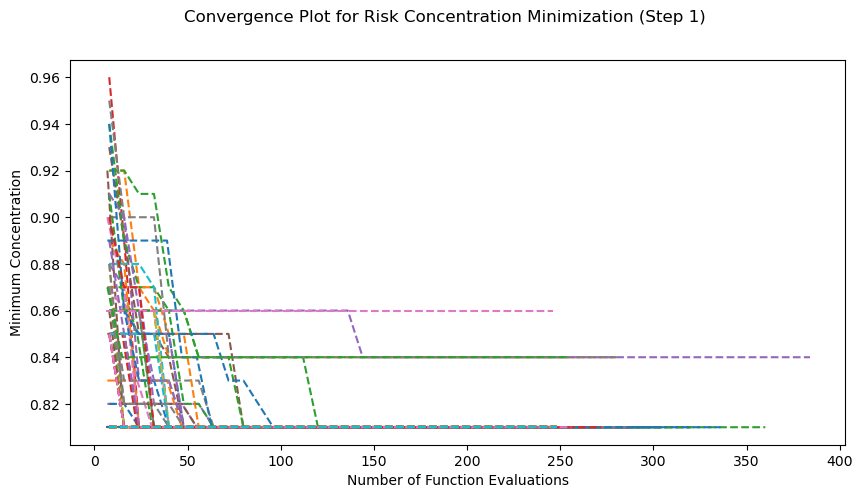

In [418]:
from tqdm import tqdm
#set number of repetitions of both minimizations (seed analysis
n_opt_rep = 100
opt_rep = range(0,n_opt_rep,1)


fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Convergence Plot for Risk Concentration Minimization (Step 1)')
#load names of countries in region which is optimized in
df_reg = sng_ann_ret.copy()
cntry_names = countries      
#optimize for each region to derive regional pool
#empty DataFrames to fill along the way (per region and GCM -> for each GCM seperate code file or change k)
#minimized concentration and number of countries (result of 1.Opt-Step and 2. Opt-Step)
df_conc = pd.DataFrame()
df_cntry_num = pd.DataFrame()
#pooled countries / "pool composition" (1=pooled, 0=not pooled)
df_cntry_allocation = pd.DataFrame(columns = cntry_names)
#end result only with solutions with min_conc and min_cntry_num
df_result = pd.DataFrame(columns = cntry_names)
#dump with all results derived for all repetitions (--> cntry_allocation, min_conc, min_cntr, (n_gen, max_n_evals for each rep) saved)
df_result_dump = pd.DataFrame()
#loop through repetitions for seed analysis
for index in tqdm(opt_rep, desc=f'Repetitions'):
    #First Optimization on minimizing Pool_C

    #Bool df where > VAR200
    bools = df_reg >= np.quantile(df_reg, alpha, axis=0)
    #Problem definition
    problem = MinConcProblem(df_reg, bools, alpha, calc_pool_conc)
    #Algorithm definition
    algorithm = GA(pop_size=df_reg.shape[1],
                   sampling=IntegerRandomSampling(),
                   crossover=HalfUniformCrossover(),
                   mutation=BitflipMutation(),
                   eliminate_duplicates=True)
    #Minimization definition
    res_reg = minimize(problem,
                       algorithm,
                       verbose=False,
                       save_history=True,
                       pf=np.array(0.0))
    #print(f"Pool has {np.sum(res_reg.X)} countries and a concentration of {res_reg.F[0]} (i.e., and diversification of {np.round(1-res_reg.F[0],2)})\
    #Indices for full regional country list
    res_reg.X
    ind = np.where(res_reg.X)
    #new row for country composition with 1=pooled and 0=not pooled
    x = []
    x = np.zeros(len(cntry_names))
    x[ind] = 1

    #test if country composition was already derived in previous run, if yes not appended, in not appended as new solution
    if df_cntry_allocation.empty or not (df_cntry_allocation == x).all(axis=1).any():
        df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
        df_conc = pd.concat([df_conc, pd.DataFrame([res_reg.F], columns=['Min_Concentration'])], ignore_index=True)
        df_cntry_num = pd.concat([df_cntry_num, pd.DataFrame([np.sum(res_reg.X)], columns=['Country_Count'])], ignore_index=True)
    else:
        None

    #new_row to dump all results with all specs derived in the two optimization steps
    new_row = pd.DataFrame(columns=[cntry_names, 
                                    'min_conc', 
                                    'min_cntry_num', 
                                    'n_gen1', 
                                    'n_eval1_max'])
    new_row = pd.DataFrame([x], columns=cntry_names)
    new_row['min_conc'] = pd.DataFrame([res_reg.F], columns = ['min_conc'])
    new_row['min_cntry_num'] = pd.DataFrame([np.sum(res_reg.X)], columns=['min_cntry_num'])
    #input for convergence plot per repetition for res_reg
    n_evals = np.array([e.evaluator.n_eval for e in res_reg.history])
    opt = np.array([e.opt[0].F for e in res_reg.history])
    ax.plot(n_evals, opt, '--')
    ax.set_ylabel('Minimum Concentration')
    ax.set_xlabel('Number of Function Evaluations')

    #convergence results for new_row (dump) from res_reg
    new_row['n_gen1'] = pd.DataFrame([res_reg.algorithm.n_gen], columns = ['n_gen1'])
    new_row['n_eval1_max'] = pd.DataFrame([n_evals.max()], columns=['n_eval1_max'])
    #append new_row to dump
    df_result_dump = pd.concat([df_result_dump, new_row], ignore_index=True)

min_conc = df_conc['Min_Concentration'].min()
#find indices where conc minimized (constraint for opt step 1)
ind_min_conc = df_conc.index[df_conc['Min_Concentration'] == min_conc].tolist() 

ind_min = list(set(ind_min_conc))

#reduce full df with cntry allocations to the rows where constraint 1 is reached
df_result = df_cntry_allocation.loc[ind_min].reset_index(drop=True)
print(df_result)

In [419]:
min_conc

0.81

In [ ]:
non_pool = df_result.loc[0, df_result.iloc[0] == 0].index.tolist()
non_pool_ret = {}
for cty in non_pool:
    non_pool_ret[cty] = sng_ann_ret[cty]
non_pool_ret = pd.DataFrame(non_pool_ret)
non_pool_bools = non_pool_ret >= np.quantile(non_pool_ret, alpha, axis=0)
cal = calc_pools_conc(np.repeat(1, len(non_pool)), non_pool_ret[non_pool].values, non_pool_bools.values, alpha, 1)
print(cal)

[212, 308, 662]


Repetitions:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\kaibe\AppData\Local\Temp\ipykernel_5828\3683328878.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
Repetitions: 100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


   212  670  308  662
0  1.0  0.0  1.0  1.0
1  0.0  0.0  1.0  1.0


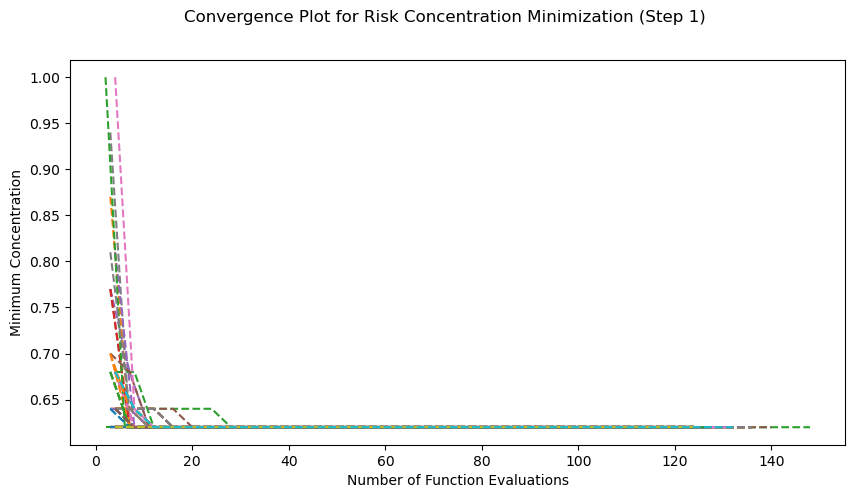

In [368]:
from tqdm import tqdm
#set number of repetitions of both minimizations (seed analysis
n_opt_rep = 100
opt_rep = range(0,n_opt_rep,1)


fig, ax = plt.subplots(1, 1, figsize=(10,5))
fig.suptitle('Convergence Plot for Risk Concentration Minimization (Step 1)')
#load names of countries in region which is optimized in
df_reg = non_pool_ret.copy()
cntry_names = non_pool      
#optimize for each region to derive regional pool
#empty DataFrames to fill along the way (per region and GCM -> for each GCM seperate code file or change k)
#minimized concentration and number of countries (result of 1.Opt-Step and 2. Opt-Step)
df_conc = pd.DataFrame()
df_cntry_num = pd.DataFrame()
#pooled countries / "pool composition" (1=pooled, 0=not pooled)
df_cntry_allocation = pd.DataFrame(columns = cntry_names)
#end result only with solutions with min_conc and min_cntry_num
df_result = pd.DataFrame(columns = cntry_names)
#dump with all results derived for all repetitions (--> cntry_allocation, min_conc, min_cntr, (n_gen, max_n_evals for each rep) saved)
df_result_dump = pd.DataFrame()
#loop through repetitions for seed analysis
for index in tqdm(opt_rep, desc=f'Repetitions'):
    #First Optimization on minimizing Pool_C

    #Bool df where > VAR200
    bools = df_reg >= np.quantile(df_reg, alpha, axis=0)
    #Problem definition
    problem = MinConcProblem(df_reg, bools.values, alpha, calc_pool_conc)
    #Algorithm definition
    algorithm = GA(pop_size=df_reg.shape[1],
                   sampling=BinaryRandomSampling(),
                   crossover=HalfUniformCrossover(),
                   mutation=BitflipMutation(),
                   eliminate_duplicates=True)
    #Minimization definition
    res_reg = minimize(problem,
                       algorithm,
                       verbose=False,
                       save_history=True,
                       pf=np.array(0.0))
    #print(f"Pool has {np.sum(res_reg.X)} countries and a concentration of {res_reg.F[0]} (i.e., and diversification of {np.round(1-res_reg.F[0],2)})\
    #Indices for full regional country list
    res_reg.X
    ind = np.where(res_reg.X)
    #new row for country composition with 1=pooled and 0=not pooled
    x = []
    x = np.zeros(len(cntry_names))
    x[ind] = 1

    #test if country composition was already derived in previous run, if yes not appended, in not appended as new solution
    if df_cntry_allocation.empty or not (df_cntry_allocation == x).all(axis=1).any():
        df_cntry_allocation = pd.concat([df_cntry_allocation, pd.DataFrame([x], columns=cntry_names)], ignore_index=True)
        df_conc = pd.concat([df_conc, pd.DataFrame([res_reg.F], columns=['Min_Concentration'])], ignore_index=True)
        df_cntry_num = pd.concat([df_cntry_num, pd.DataFrame([np.sum(res_reg.X)], columns=['Country_Count'])], ignore_index=True)
    else:
        None

    #new_row to dump all results with all specs derived in the two optimization steps
    new_row = pd.DataFrame(columns=[cntry_names, 
                                    'min_conc', 
                                    'min_cntry_num', 
                                    'n_gen1', 
                                    'n_eval1_max'])
    new_row = pd.DataFrame([x], columns=cntry_names)
    new_row['min_conc'] = pd.DataFrame([res_reg.F], columns = ['min_conc'])
    new_row['min_cntry_num'] = pd.DataFrame([np.sum(res_reg.X)], columns=['min_cntry_num'])
    #input for convergence plot per repetition for res_reg
    n_evals = np.array([e.evaluator.n_eval for e in res_reg.history])
    opt = np.array([e.opt[0].F for e in res_reg.history])
    ax.plot(n_evals, opt, '--')
    ax.set_ylabel('Minimum Concentration')
    ax.set_xlabel('Number of Function Evaluations')

    #convergence results for new_row (dump) from res_reg
    new_row['n_gen1'] = pd.DataFrame([res_reg.algorithm.n_gen], columns = ['n_gen1'])
    new_row['n_eval1_max'] = pd.DataFrame([n_evals.max()], columns=['n_eval1_max'])
    #append new_row to dump
    df_result_dump = pd.concat([df_result_dump, new_row], ignore_index=True)

min_conc = df_conc['Min_Concentration'].min()
#find indices where conc minimized (constraint for opt step 1)
ind_min_conc = df_conc.index[df_conc['Min_Concentration'] == min_conc].tolist() 

ind_min = list(set(ind_min_conc))

#reduce full df with cntry allocations to the rows where constraint 1 is reached
df_result = df_cntry_allocation.loc[ind_min].reset_index(drop=True)
print(df_result)

In [369]:
min_conc

0.62

## Designe Multi-Country Bond
### Set Variables for Multi-Country Bond

### Create Multi-Country bond

In [ ]:
tranches_array = np.array([20, 100, 250, 500, 2000])

nominal_dic = {}
pay_dam_df_dic = {}
for cty in countries:
    nominal_dic[cty] = nominal_sng_dic[cty]
    pay_dam_df_dic[cty] = pay_dam_df_sng_dic[cty]
    
ncf_pool1, premiums_pool1, premium_dic_pool1, nominal_pool1, es_metrics_pool1, MES_cty_pool1, tranches1 = bond_fct.mlt_cty_bond(countries=pool1,pay_dam_df_dic=pay_dam_df_dic,nominals_dic=nominal_dic, tranches_array=tranches_array, opt_cap=True)

ncf_pool2, premiums_pool2, premium_dic_pool2, nominal_pool2, es_metrics_pool2, MES_cty_pool2, tranches2 = bond_fct.mlt_cty_bond(countries=pool2,pay_dam_df_dic=pay_dam_df_dic,nominals_dic=nominal_dic, tranches_array=tranches_array, opt_cap=True)

In [ ]:
sng_ann_ret = {}
pool_sng_ann_ret = {}
for cty in countries:
    sng_ann_ret[cty] = returns_sng_dic[cty]['Annual'][0] 
for key in ncf_pool1:
    if key != 'Total':
        pool_sng_ann_ret[key] = ncf_pool1[key] / tranches1.loc[tranches1['RP'] == key, 'nominal'].iloc[0]
for key in ncf_pool2:
    if key != 'Total':
        pool_sng_ann_ret[f"2: {key}"] = ncf_pool2[key] / tranches2.loc[tranches1['RP'] == key, 'nominal'].iloc[0]


pool_ann_ret_1 = ncf_pool1['Total']
pool_ann_ret_2 = ncf_pool2['Total']

In [ ]:
df_returns = pd.DataFrame({f"{country} Returns": returns for country, returns in sng_ann_ret.items()})
df_returns_pool = pd.DataFrame({f"{country} Returns": returns for country, returns in pool_sng_ann_ret.items()})

r = np.mean(df_returns,axis=0)
r_pool= np.mean(df_returns_pool,axis=0)

# Create a covariance matrix
covar = df_returns.cov()
covar_pool = df_returns_pool.cov()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Simulated covariance matrix of bonds
cov_matrix = np.array(covar)
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Make symmetric
np.fill_diagonal(cov_matrix, 1)  # Set variances to 1

# Convert covariance to distance (1 - covariance)
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

# Perform hierarchical clustering
distance_matrix = 1 - cov_matrix
linkage_matrix = linkage(squareform(distance_matrix), method='ward')  # 'ward' minimizes variance
labels = fcluster(linkage_matrix, t=2, criterion='maxclust')  # 2 groups

# Grouping bonds
group_1 = np.where(labels == 1)[0]
group_2 = np.where(labels == 2)[0]

print("Group 1 Bonds:", group_1)
print("Group 2 Bonds:", group_2)


In [ ]:
import numpy as np
from scipy.optimize import minimize

# Simulated covariance matrix
n_bonds = len(covar)
cov_matrix = np.array(covar)
cov_matrix = (cov_matrix + cov_matrix.T) / 2  # Make symmetric
np.fill_diagonal(cov_matrix, 1)

# Number of bonds in each group (balanced sizes)
group_size = n_bonds // 2
if n_bonds % 2 != 0:
    group_size_1 = group_size + 1  # For odd number of bonds
    group_size_2 = group_size
else:
    group_size_1 = group_size
    group_size_2 = group_size

# Objective function: minimize the sum of covariances with a penalty for group size imbalance
def objective(labels):
    group_1 = np.where(labels >= 0.5)[0]  # Group 1: labels >= 0.5
    group_2 = np.where(labels < 0.5)[0]   # Group 2: labels < 0.5
    
    # Calculate the sum of intra-group covariances
    cov_1 = cov_matrix[np.ix_(group_1, group_1)].sum() if len(group_1) > 0 else 0
    cov_2 = cov_matrix[np.ix_(group_2, group_2)].sum() if len(group_2) > 0 else 0
    
    # Penalty term for group size imbalance
    penalty = abs(len(group_1) - group_size_1) + abs(len(group_2) - group_size_2)
    
    # Return the sum of covariances plus a penalty for group size imbalance
    return cov_1 + cov_2 + 100 * penalty  # 100 is a large weight for the penalty

# Constraints to ensure binary assignments (labels are either 0 or 1)
def constraint(labels):
    return np.sum(labels) - group_size_1  # Group 1 must have 'group_size_1' bonds

# Optimization to minimize the sum of covariances with group size penalty
initial_labels = np.random.rand(n_bonds)  # Random initial labels
bounds = [(0, 1)] * n_bonds  # Binary decision variables
constraints = [{'type': 'eq', 'fun': constraint}]  # Ensure exact group sizes

# Solve the optimization problem
result = minimize(
    objective,
    initial_labels,
    bounds=bounds,
    constraints=constraints,
    method="SLSQP",  # Sequential Least Squares Quadratic Programming
    options={'disp': True}
)

# Extract the final labels and round them to get binary assignments (0 or 1)
final_labels = np.round(result.x).astype(int)

# Group bonds based on final labels
group_1 = np.where(final_labels == 1)[0].tolist()
group_2 = np.where(final_labels == 0)[0].tolist()

# Print the results
print("Group 1 Bonds:", group_1)
print("Group 2 Bonds:", group_2)

# Calculate and print the covariance of each pool
cov_1 = cov_matrix[np.ix_(group_1, group_1)].sum() if group_1 else 0
cov_2 = cov_matrix[np.ix_(group_2, group_2)].sum() if group_2 else 0

print("Covariance of Group 1:", cov_1)
print("Covariance of Group 2:", cov_2)

# Print the sizes of each group
print("Size of Group 1:", len(group_1))
print("Size of Group 2:", len(group_2))


In [ ]:
from sklearn.cluster import SpectralClustering

# Spectral Clustering
n_clusters = 2
spectral = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = spectral.fit_predict(cov_matrix)


# Grouping bonds
group_1 = np.where(labels == 0)[0]
group_2 = np.where(labels == 1)[0]

print("Group 1 Bonds:", group_1)
print("Group 2 Bonds:", group_2)


In [ ]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df_returns.columns)

p_ret_pool = [] # Define an empty array for portfolio returns
p_vol_pool = [] # Define an empty array for portfolio volatility
p_weights_pool = [] # Define an empty array for asset weights

num_assets_pool = len(df_returns_pool.columns)

num_portfolios = 10000  # Number of portfolios to simulate
alpha = 0.5

In [ ]:
from numpy.random import dirichlet

for _ in range(num_portfolios):
    weights = dirichlet([alpha] * num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, r) 
    p_ret.append(returns)
    var = covar.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # yearly standard deviation
    p_vol.append(sd)    

    weights_pool = dirichlet([alpha] * num_assets_pool)
    weights_pool = weights_pool/np.sum(weights_pool)
    p_weights_pool.append(weights_pool)
    returns_pool = np.dot(weights_pool, r_pool) 
    p_ret_pool.append(returns_pool)
    var_pool = covar_pool.mul(weights_pool, axis=0).mul(weights_pool, axis=1).sum().sum()# Portfolio Variance
    sd_pool = np.sqrt(var_pool) # yearly standard deviation
    p_vol_pool.append(sd_pool)

In [ ]:
data = {'Returns':p_ret, 'Volatility':p_vol, 'Sharpe Ratio':np.array(p_ret)/np.array(p_vol)}
data_pool = {'Returns':p_ret_pool, 'Volatility':p_vol_pool, 'Sharpe Ratio':np.array(p_ret_pool)/np.array(p_vol_pool)}

for counter, symbol in enumerate(df_returns.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

for counter, symbol in enumerate(df_returns_pool.columns.tolist()):
    data_pool[symbol+' weight'] = [w[counter] for w in p_weights_pool]

In [ ]:
portfolios  = pd.DataFrame(data)
max_sharpe_idx = portfolios['Sharpe Ratio'].idxmax()
max_sharpe_portfolio = portfolios.loc[max_sharpe_idx]
portfolios.head() # Dataframe of the 10000 portfolios created


portfolios_pool  = pd.DataFrame(data_pool)
max_sharpe_idx_pool = portfolios_pool['Sharpe Ratio'].idxmax()
max_sharpe_portfolio_pool = portfolios_pool.loc[max_sharpe_idx_pool]

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as sco

# Expected returns and covariance matrices
r = np.mean(df_returns, axis=0)  # Expected returns for df_returns
r_pool = np.mean(df_returns_pool, axis=0)  # Expected returns for df_returns_pool

covar = df_returns.cov()  # Covariance matrix for df_returns
covar_pool = df_returns_pool.cov()  # Covariance matrix for df_returns_pool

# Function to calculate portfolio risk (standard deviation)
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

# Function for optimization: minimize risk for a given return
def minimize_risk(target_return, mean_returns, cov_matrix):
    # Number of assets in the portfolio
    num_assets = len(mean_returns)
    
    # Constraints: weights sum to 1, and portfolio return equals target return
    constraints = ({
        'type': 'eq', 'fun': lambda w: np.sum(w) - 1  # Weights sum to 1
    }, {
        'type': 'eq', 'fun': lambda w: portfolio_return(w, mean_returns) - target_return  # Target return constraint
    })
    
    # Initial guess: equal weights
    initial_guess = np.ones(num_assets) / num_assets
    
    # Bounds for weights: between 0 and 1
    bounds = tuple((0, 1) for asset in range(num_assets))
    
    # Minimize risk (objective function)
    result = sco.minimize(portfolio_risk, initial_guess, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x, result.fun  # Return the optimized weights and the minimized risk

# Generate a series of target returns and corresponding risks
target_returns = np.linspace(np.min(r), np.max(r), 50)  # Range of target returns
risks = []

for target_return in target_returns:
    weights, risk = minimize_risk(target_return, r, covar)
    risks.append(risk)

## Repeat for the second data set (df_returns_pool)
risks_pool = []
target_returns_pool = np.linspace(np.min(r_pool), np.max(r_pool), 50)
for target_return in target_returns_pool:
    weights, risk = minimize_risk(target_return, r_pool, covar_pool)
    risks_pool.append(risk)


In [ ]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='cividis', marker='v', s=10, alpha=0.3, grid=True, figsize=[10,10])
plt.text(max_sharpe_portfolio['Volatility'] + 0.001,max_sharpe_portfolio['Returns'],f"Max Sharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.plot(risks, target_returns, label="Efficient Frontier - Sng", color='blue')
plt.scatter(x=portfolios_pool['Volatility'], y=portfolios_pool['Returns'], c=portfolios_pool['Sharpe Ratio'], cmap='cividis', marker='o', s=10, alpha=0.3)
plt.text(max_sharpe_portfolio_pool['Volatility'] + 0.001,max_sharpe_portfolio_pool['Returns'],f"Max Sharpe: {max_sharpe_portfolio_pool['Sharpe Ratio']:.2f}",fontsize=10,ha='left',va='center',color='red')
plt.scatter(x=max_sharpe_portfolio_pool['Volatility'], y=max_sharpe_portfolio_pool['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.scatter(x=max_sharpe_portfolio['Volatility'], y=max_sharpe_portfolio['Returns'], color='red', marker='x', s=10, alpha=1.0)
plt.plot(risks_pool, target_returns_pool, label="Efficient Frontier - Pool", color='red')

# Plot pool point
plt.scatter(np.std(pool_ann_ret_1), np.mean(pool_ann_ret_1), label='Pool', color='purple', s=100)
plt.text(np.std(pool_ann_ret_1)-0.01,np.mean(pool_ann_ret_1),f'Sharpe: {np.mean(pool_ann_ret_1)/np.std(pool_ann_ret_1):.2f}',fontsize=10,ha='right',va='center',color='purple')

plt.scatter(np.std(pool_ann_ret_2), np.mean(pool_ann_ret_2), label='Pool', color='purple', s=100)
plt.text(np.std(pool_ann_ret_2)-0.01,np.mean(pool_ann_ret_2),f'Sharpe: {np.mean(pool_ann_ret_2)/np.std(pool_ann_ret_2):.2f}',fontsize=10,ha='right',va='center',color='purple')

for cty in countries:
    plt.scatter(np.std(sng_ann_ret[cty]), np.mean(sng_ann_ret[cty]), label=cty, s=100)
plt.legend()

In [ ]:
closest_index = (portfolios['Volatility'] - np.std(pool_ann_ret)).abs().idxmin()

# Extract the corresponding return
closest_return = portfolios.loc[closest_index, 'Returns']
closest_volatility = portfolios.loc[closest_index, 'Volatility']
print(np.mean(pool_ann_ret) - closest_return)
print(np.std(pool_ann_ret) - closest_volatility)


In [ ]:
x = countries.copy()
x = [str(entry) for entry in x]
x.append('pool_1')
x.append('pool_2')
y = []
for cty in countries:
    y.append(bond_metrics_sng_dic[cty]['Total Premiums'][0]/bond_metrics_sng_dic[cty]['Summed Payments'][0])
y.append(np.sum(premiums_pool1['Total'])/(es_metrics_pool1['Payout']/nominal_pool1))
y.append(np.sum(premiums_pool2['Total'])/(es_metrics_pool2['Payout']/nominal_pool2))
print(y)
plt.scatter(x,y)

In [ ]:
s = []
s_pool = []
n = []
for cty in countries:
    s.append(bond_metrics_sng_dic[cty]['Total Premiums'][0])
    if cty in premiums_pool1:
        s_pool.append(np.sum(premiums_pool1[cty])*nominal_pool1)
    else:
        s_pool.append(np.sum(premiums_pool2[cty])*nominal_pool2)
    n.append(nominal_sng_dic[cty])

print((np.sum(premiums_pool1['Total'])*nominal_pool1 + np.sum(premiums_pool2['Total'])*nominal_pool2)/np.sum(s))
print((nominal_pool1+nominal_pool2)/np.sum(n))
print(np.array(s_pool)/np.array(s))
country_str = [str(entry) for entry in countries]

plt.scatter(country_str, np.array(s_pool)/np.array(s))